<a href="https://colab.research.google.com/github/Anup-Sarkar-DD/GoogleColab_repo/blob/main/SarcasmDL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import tensorflow as tf
import requests
import re
import string

# Suppress warnings
warnings.filterwarnings('ignore')

# Load sarcasm dataset
url = "https://storage.googleapis.com/learning-datasets/sarcasm.json"
response = requests.get(url)
data = response.json()

# Convert to DataFrame
df = pd.DataFrame(data)
df = df.drop(columns='article_link')

# Clean text function
def clean_text(text):
    text = text.lower()
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)
    return text

# Apply text cleaning
df['headline'] = df['headline'].apply(clean_text)

# Features and labels
x = df['headline']
y = df['is_sarcastic']

# Split data
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.22, random_state=42, stratify=y
)

# Tokenization and padding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

vocab_size = 10000
max_length = 100
oov_tok = "<OOV>"
padding_type = 'post'
trunc_type = 'post'
embedding_dim = 16

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(x_train)

x_train_seq = tokenizer.texts_to_sequences(x_train)
x_test_seq = tokenizer.texts_to_sequences(x_test)

x_train_padded = pad_sequences(x_train_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)
x_test_padded = pad_sequences(x_test_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)



In [2]:
# Build the model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    GlobalAveragePooling1D(),
    Dense(24, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile and build model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.build(input_shape=(None, max_length))  # Ensures model is built
model.summary()



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 16)        │       160,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 16)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 24)             │           408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            25 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 160,433 (626.69 KB)

 Trainable params: 160,433 (626.69 KB)

 Non-trainable params: 0 (0.00 B)

In [3]:

# Train the model
history = model.fit(
    x_train_padded, y_train,
    epochs=10,
    validation_data=(x_test_padded, y_test),
    verbose=2
)


Epoch 1/10
652/652 - 5s - 7ms/step - accuracy: 0.5704 - loss: 0.6778 - val_accuracy: 0.6341 - val_loss: 0.6403
Epoch 2/10
652/652 - 2s - 4ms/step - accuracy: 0.7503 - loss: 0.5247 - val_accuracy: 0.6361 - val_loss: 0.6896
Epoch 3/10
652/652 - 3s - 4ms/step - accuracy: 0.8195 - loss: 0.4117 - val_accuracy: 0.8273 - val_loss: 0.3935
Epoch 4/10
652/652 - 4s - 6ms/step - accuracy: 0.8501 - loss: 0.3538 - val_accuracy: 0.8305 - val_loss: 0.3816
Epoch 5/10
652/652 - 2s - 4ms/step - accuracy: 0.8665 - loss: 0.3209 - val_accuracy: 0.8329 - val_loss: 0.3685
Epoch 6/10
652/652 - 3s - 4ms/step - accuracy: 0.8805 - loss: 0.2965 - val_accuracy: 0.8548 - val_loss: 0.3435
Epoch 7/10
652/652 - 2s - 4ms/step - accuracy: 0.8927 - loss: 0.2692 - val_accuracy: 0.8227 - val_loss: 0.4032
Epoch 8/10
652/652 - 3s - 5ms/step - accuracy: 0.9033 - loss: 0.2460 - val_accuracy: 0.8570 - val_loss: 0.3352
Epoch 9/10
652/652 - 5s - 7ms/step - accuracy: 0.9104 - loss: 0.2298 - val_accuracy: 0.8462 - val_loss: 0.3633
E

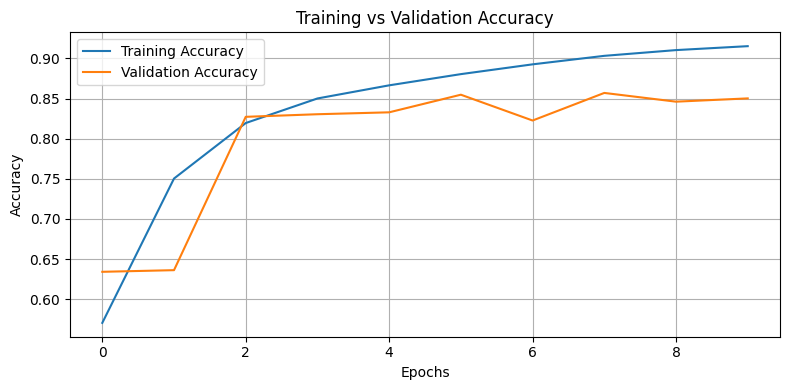

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
Text: I'm so thrilled to wait in line for hours.
 → Prediction: Sarcastic (Confidence: 0.98)

Text: The sun is shining brightly.
 → Prediction: Not Sarcastic (Confidence: 0.04)



In [4]:

# Plot accuracy
plt.figure(figsize=(8, 4))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Sample predictions
sample_texts = ["I'm so thrilled to wait in line for hours.", "The sun is shining brightly."]
sample_cleaned = [clean_text(t) for t in sample_texts]
sample_seq = tokenizer.texts_to_sequences(sample_cleaned)
sample_pad = pad_sequences(sample_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)
predictions = model.predict(sample_pad)

# Show predictions
for i, text in enumerate(sample_texts):
    label = "Sarcastic" if predictions[i][0] > 0.5 else "Not Sarcastic"
    print(f"Text: {text}\n → Prediction: {label} (Confidence: {predictions[i][0]:.2f})\n")